# CIFAR-10 Challenge

En este práctico intentaremos resolver el challenge CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html) creando una red convolucional desde cero con Keras, y luego compararemos su performance con la obtenida al realizar Transfer Learning partiendo de alguna arquitectura conocida.

## Preparación y visualización de los datos

Empezamos por importar y cargar el dataset, que ya viene separado en conjuntos de entrenamiento y evaluación.

Por ahora no nos preocuparemos por tener una partición para validación durante el entrenamiento, Keras nos va a proveer una forma fácil de hacerlo al momento de entrenar nuestros modelos.

In [ ]:
import numpy as np
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Los datos vienen con valores RGB en el rango [0, 255], necesitamos llevarlos a [0,1]:

In [ ]:
x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype('float32')/255.0

### Ejercicio 1 - Datos básicos de CIFAR-10

1. ¿Cuántos ejemplos tiene cada partición (entrenamiento y evaluación)?
1. ¿De qué tamaño son las imágenes del dataset?
1. ¿Cuántos canales tienen las imágenes del dataset?
1. ¿Cuántas categorías tiene el dataset?
1. ¿Cuántas imágenes por categoría hay en el conjunto de entrenamiento?

In [ ]:
# código para responder las preguntas

print(f'Datos de entrenamiento son de forma: {x_train.shape}')
print(f'Etiquetas de datos de entrenamiento son de forma: {y_train.shape}')
print(f'Datos de testeo son de forma: {x_test.shape}')
print(f'Etiquetas de datos de testeo son de forma: {y_test.shape}\n')

# x_train:
#   50000 ejemplos. Cada uno es una matriz de 32x32
#   El elemento (i,j) de cada matriz es en sí mismo un
#   array de 3 elementos, conteniendo los valores de los píxeles para cada canal.
#   Por eso, x_train[0][0][0].shape = 3.

for label,count in zip(np.unique(y_train, return_counts = True)[0], np.unique(y_train, return_counts = True)[1]):
  print (f'Clase {label}: {count} ejemplos')
print(f'Total: {len(y_train)} ejemplos')

Datos de entrenamiento son de forma: (50000, 32, 32, 3)
Etiquetas de datos de entrenamiento son de forma: (50000, 1)
Datos de testeo son de forma: (10000, 32, 32, 3)
Etiquetas de datos de testeo son de forma: (10000, 1)

Clase 0: 5000 ejemplos
Clase 1: 5000 ejemplos
Clase 2: 5000 ejemplos
Clase 3: 5000 ejemplos
Clase 4: 5000 ejemplos
Clase 5: 5000 ejemplos
Clase 6: 5000 ejemplos
Clase 7: 5000 ejemplos
Clase 8: 5000 ejemplos
Clase 9: 5000 ejemplos
Total: 50000 ejemplos


### Respuestas
1. El conjunto de entrenamiento tiene 50000 ejemplos, mientras que el de evaluación tiene 10000 ejemplos
2. Las imágenes son de 32x32 píxeles
3. Cada imagen tiene 3 canales
4. El dataset tiene 10 categorías (0 a 9)
5. Se tienen 5000 imágenes por categoría en el conjunto de entrenamiento

#### Pistas

Para las tres primeras preguntas, basta con explorar las dimensiones de las variables `x_train` y `x_test` con el atributo `shape`. Las dimensiones tienen la forma (N, W, H, C), donde:
* N es la cantidad de imágenes
* W es el ancho de cada imagen
* H es el alto de cada imagen
* C es la cantidad de canales de cada imagen.

Para las últimas preguntas, `np.unique` puede ser útil. Revisar la documentación: https://numpy.org/doc/stable/reference/generated/numpy.unique.html

### Visualización

Observamos que las etiquetas están codificadas como enteros, de 0 a 9. Para hacerlas legibles al momento de desplegarlas luego, utilizaremos la siguiente variable:

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Para visualizar imágenes del conjunto de entrenamiento podemos utilizar `matplotlib`:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

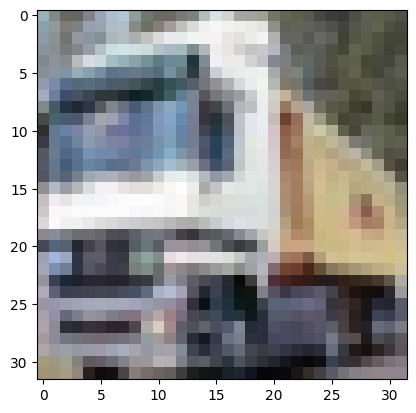

Etiqueta: TRUCK


In [ ]:
plt.imshow(x_train[1])
plt.show()
print(f'Etiqueta: {labels[y_train[1][0]].upper()}')

### Ejercicio 2 (opcional) - Mostrar imágenes aleatorias de una categoría

Definir una función `show_random_image` que recibe como parámetro una de las categorías de CIFAR-10 y muestra una imagen aleatoria del conjunto de entrenamiento perteneciente a esa categoría.

In [ ]:
def show_random_image(label: str):
  # completar

  # Filtrado de x_train según label
  label_num = labels.index(label)
  mask = (y_train == label_num)
  x_train_filtered = x_train[mask[:,0]]

  # Generación de número aleatorio entre 0 y 4999
  num = np.random.randint(0,x_train_filtered.shape[0]-1)

  # Imagen y etiqueta
  plt.imshow(x_train_filtered[num])
  plt.show()
  print (f'Etiqueta {label.upper()}')

#### Pistas

Tratar de resolver el problema siguiendo estos pasos:
1. filtrar `x_train` para quedarnos sólo con las imágenes que pertenecen a la categoría recibida
  * convertir el `string` de la categoría en un entero utilizando `labels`
  * obtener una lista de booleanos del largo de `y_train` con valores `True` en las posiciones que coinciden con el índice del paso anterior
  * utilizar boolean indexing para quedarnos sólo con las imágenes `x_train` que cumplen la condición
1. utilizar `np.random.choice` para elegir un índice del dataset filtrado de forma aleatoria (https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)
* finalmente, desplegar la imagen con `matlplotlib` como se hizo antes.

## Redes convolucionales en Keras

Comenzaremos a explorar las herramientas que Keras nos ofrece para construir redes convolucionales. Utilizaremos nuevamente la API Sequential, y en particular las clases `Conv2D`, `MaxPool2D` y `Flatten`, además de las que ya vimos en clases anteriores.

### Ejercicio 3: Bloque convolucional

Considerando el tamaño de entrada de las imágenes de CIFAR-10, y el siguiente bloque convolucional:

1. Entrada
1. Capa convolucional, 32 filtros de tamaño (3,3), zero
padding de 1px, stride de 1px.
1. Activación: ReLU.
1. Capa convolucional, 64 filtros de tamaño (3,3), sin padding, stride de 1px.
1. Activación: ReLU.
1. MaxPooling de (2,2), stride 2.

Calcular la cantidad de parámetros total, y las dimensiones de la salida luego del MaxPooling.

ESTUDIANTES: AGREGAR AQUÍ EL TEXTO CON EL DESARROLLO DE LA SOLUCION PARA LA ENTREGA

###**1era capa**
Dado que las imágenes y el filtro son cuadrados, la salida de cada filtro también será cuadrada. Cada dimensión será de (32-3+2x1)/1 + 1 = 32. Entonces, dado que se tienen 32 filtros, la salida será de 32x32x32.

Dado que la entrada de la 1era capa es de 32x32x3, cada filtro tendrá 3x3x3 = 27 parámetros. Luego, dado que se aplican 32 filtros, la cantidad de parámetros de esta capa será 27x32 + 32 = 896, considerando los parámetros de sesgo para cada filtro.


###**2da capa**
Dado que la salida de la primera capa es de 32x32x32 y que nuevamente los filtros son cuadrados, la salida de la segunda capa también será cuadrada, con dimensión (32-3+2x0)/1 + 1 = 30. Luego, dado que se aplican 64 filtros, la salida de esta capa será de 30x30x64.

Dado que la entrada de la 2da capa es la salida de la 1era capa, la misma será de 32x32x32, por lo que cada filtro tendrá 3x3x32 = 288 parámetros. Luego, dado que se aplican 64 filtros, la cantidad de parámetros de esta capa será 288x64 + 64 = 18496, considerando los parámetros de sesgo para cada filtro.

###**MaxPooling**
La salida de la 2da capa es de 30x30x64, lo que quiere decir que consta de 64 matrices de 30x30. La aplicación de MaxPooling de 2x2 con stride de 2 a cada una de esas matrices las reduce a una matriz cuadrada de dimensiones (30-2)/2+1 = 15. Es decir, la salida del bloque convolucional será de 15x15x64.

###**Final**
La salida del bloque convolucional es de 15x15x64.

Dado que la capa de MaxPooling no agrega parámetros, la cantidad total de parámetros es la suma de los de la 1era y 2da capa. Entonces, se tendrán 896 + 18496 = 19392 parámetros

### Ejercicio 4: Implementación en Keras

Utilizando la API sequencial de Keras, y las capas `Conv2D` y `MaxPool2D`, completar la implementación del bloque convolucional del ejercicio anterior. Corroborar los cálculos anteriores utilizando el método `summary`. Documentación:
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://keras.io/api/layers/pooling_layers/max_pooling2d/


In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D

In [ ]:
model = Sequential()

model.add(Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', strides = 1, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_99 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Completando la arquitectura

Hasta ahora tenemos sólo un bloque convolucional básico, con un volumen como salida. Para poder entrenar un modelo para CIFAR-10, precisamos completar la arquitectura de forma de que la salida sea una predicción de categoría.

Lo primero que tenemos que hacer, es utilizar la capa especial `Flatten` (https://keras.io/api/layers/reshaping_layers/flatten/) que se encarga de "achatar"  el volumen de salida de la última capa, convirtiéndolo en un arreglo de una única dimensión. Además, esta capa no agrega parámetros, ya que sólo es un reshape. Podemos comprobar ambas aspectos observando la salida de `summary` nuevamente:

In [ ]:
model.add(Flatten())
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_99 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ahora, con estas dimensiones, ya podemos agregar una capa fully connected que será nuestra capa de salida, con las dimensiones adecuadas a nuestro problema (la cantidad de categorías de salida) y activación `softmax`:



In [ ]:
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_99 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                144010    
                                                                 
Total params: 163402 (638.29 KB)
Trainable params: 163402 (638.29 KB)
Non-trainable params: 0 (0.00 Byte)
______________

### Ejercicio 5: Compilar y entrenar

Con la arquitectura completa estamos listos para compilar el modelo y ponerlo a entrenar. Completar las siguientes celdas, considerando los siguientes puntos:
* utilizar `Adam` con learning rate de 0.001
* utilizar una loss adecuada al formato de etiquetas que tenemos.  
* utilizar `accuracy` como métrica de optimización
* entrenar el modelo utilizando la partición de entrenamiento, separando un 10% para validar durante el entrenamiento
* entrenar el modelo durante 10 épocas

Documentación:
* https://keras.io/api/optimizers/adam/
* https://keras.io/api/losses/

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(x = x_train,
          y = y_train,
          epochs = 10,
          validation_data = (x_val, y_val)
          )

# código para compilar y entrenar el modelo, no debería ser más de dos o tres líneas

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3632 - accuracy: 0.5190 - val_loss: 1.0988 - val_accuracy: 0.6076
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0000 - accuracy: 0.6541 - val_loss: 1.0135 - val_accuracy: 0.6496
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8651 - accuracy: 0.7033 - val_loss: 1.0014 - val_accuracy: 0.6618
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7638 - accuracy: 0.7372 - val_loss: 0.9810 - val_accuracy: 0.6714
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6746 - accuracy: 0.7703 - val_loss: 0.9650 - val_accuracy: 0.6748
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5999 - accuracy: 0.7928 - val_loss: 1.0340 - val_accuracy: 0.6712
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5299 - accuracy: 0.8156 - val_loss: 1.0545 - val_accuracy:

### Visualizar la historia de entrenamiento

Utilizaremos la función `plot_history` para ver cómo evolucionaron la accuracy y la loss durante el entrenamiento:

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

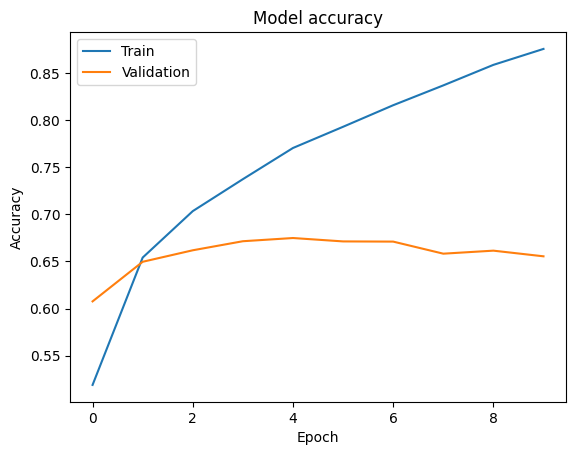

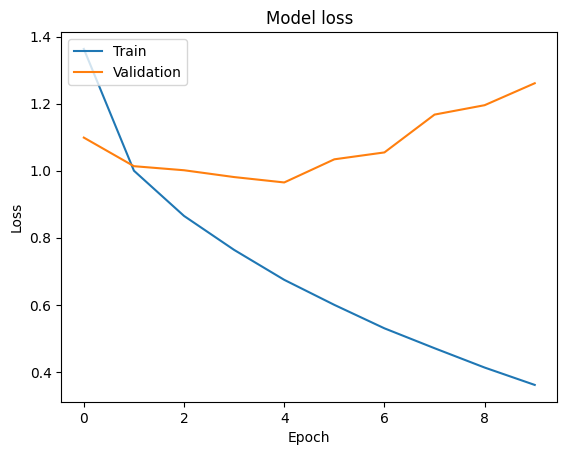

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(model.history)

### Ejercicio 6: Controlando el sobreajuste

Si bien los resultados en la partición de entrenamiento no están nada mal, en el conjunto de validación no pasa lo mismo. Tenemos un claro sobreajuste. Vamos a agregar una capa FC más y un par de capas de Dropout, para mejorar este aspecto.

Redefinir la arquitectura anterior, ajustando los siguientes puntos:
* ajustar la primer capa convolucional para que tenga 64 filtros y padding `same`
* ajustar la segunda capa convolucional para que tenga 128 filtros y padding `same`
* agregar una capa de `Dropout` con ratio `0.5` luego de la capa `MaxPool2D`
* agregar una nueva capa `Dense` con 256 neuronas y activación `relu` luego de la capa `Flatten`
* agregar una capa de `Dropout` con ratio `0.5` luego de la capa `Dense` anterior

Volver a compilar y entrenar el modelo.

In [ ]:
from keras.layers import Dropout

model = Sequential()

model.add(Input(shape=(32,32,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2))

# agregar Dropout aquí
model.add(Dropout(rate = 0.5, seed = 6))

model.add(Flatten())

# agregar otra capa Dense aquí
model.add(Dense(256, activation='relu'))

# agregar Dropout aquí
model.add(Dropout(rate = 0.5, seed = 6))

model.add(Dense(10, activation='softmax'))

# código para compilar y entrenar el nuevo modelo
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(x = x_train,
          y = y_train,
          epochs = 10,
          validation_data = (x_val, y_val)
          )


Epoch 1/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5014 - accuracy: 0.4608 - val_loss: 1.1607 - val_accuracy: 0.5906
Epoch 2/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.2011 - accuracy: 0.5750 - val_loss: 1.0108 - val_accuracy: 0.6368
Epoch 3/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.0821 - accuracy: 0.6196 - val_loss: 0.9605 - val_accuracy: 0.6604
Epoch 4/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.0039 - accuracy: 0.6458 - val_loss: 0.9342 - val_accuracy: 0.6692
Epoch 5/10
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9498 - accuracy: 0.6628 - val_loss: 0.8710 - val_accuracy: 0.6934
Epoch 6/10
1407/1407 [==============================] - 13s 9ms/step - loss: 0.8904 - accuracy: 0.6865 - val_loss: 0.8592 - val_accuracy: 0.7018
Epoch 7/10
1407/1407 [==============================] - 13s 9ms/step - loss: 0.8541 - accuracy: 0.6981 - val_loss: 0.8789 - val_a

Ahora podemos revisar nuevamente las curvas de evolución de la loss y la accuracy:

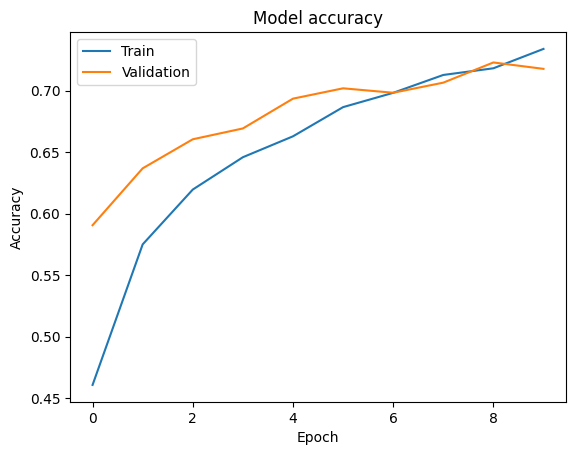

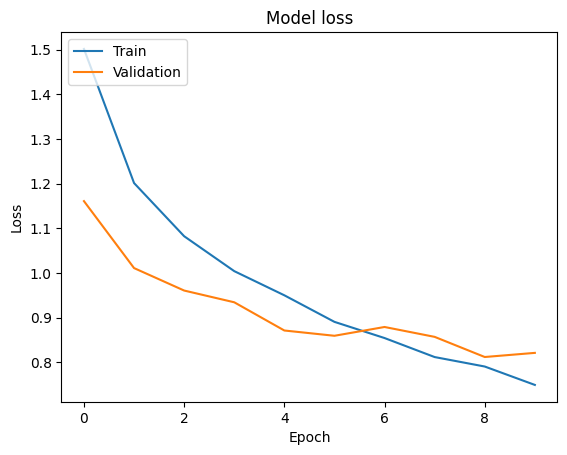

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(model.history)

### Ejercicio 7: Evaluación

Finalmente, evaluamos nuestro modelo. Primero visualizaremos algunas predicciones, y luego obtendremos la accuracy total sobre el conjunto de evaluación.

1. Obtener las predicciones del modelo sobre el conjunto de evaluación (`x_test`).
1. Mostrar la primer imagen del conjunto de evaluación junto con su predicción (utilizar la variable `labels`).
1. Obtener la accuracy del modelo sobre el conjunto de evaluación. Utilizar `sklearn.metrics.accuracy_score`. NOTA: Tener cuidado con el formato de las variables, va a ser necesario transformar las predicciones.


313/313 [==============================] - 1s 2ms/step


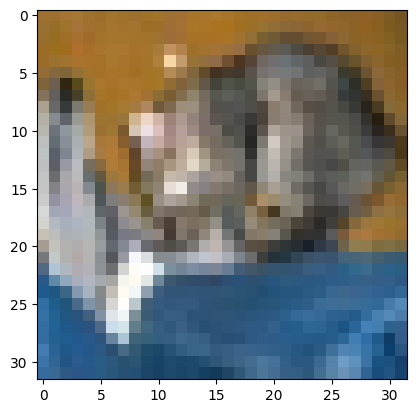

Etiqueta: CAT

Accuracy on test set: 0.7071

------------------------ CLASSIFICATION REPORT ------------------------
              precision    recall  f1-score   support

           0      0.771     0.723     0.746      1000
           1      0.835     0.819     0.827      1000
           2      0.640     0.478     0.547      1000
           3      0.512     0.560     0.535      1000
           4      0.621     0.723     0.668      1000
           5      0.652     0.570     0.608      1000
           6      0.678     0.847     0.753      1000
           7      0.799     0.732     0.764      1000
           8      0.818     0.809     0.813      1000
           9      0.774     0.810     0.791      1000

    accuracy                          0.707     10000
   macro avg      0.710     0.707     0.705     10000
weighted avg      0.710     0.707     0.705     10000



In [ ]:
# código para evaluar el modelo
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Predicciones
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

# Primera imagen
plt.imshow(x_test[0])
plt.show()

# Métricas
print(f'Etiqueta: {labels[y_pred[0]].upper()}')
print(f'\nAccuracy on test set: {accuracy_score(y_true = y_test, y_pred = y_pred)}')
print ('\n------------------------ CLASSIFICATION REPORT ------------------------')
print(classification_report(y_true = y_test, y_pred = y_pred, digits = 3))


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               8388864   
                                                      

## Transfer Learning

Ahora vamos a probar utilizar transfer learning para poder aprovechar alguna red pre-entrenada y ajustarla a nuestro problema. Los modelos disponibles en Keras están listados acá: https://keras.io/api/applications/. También se incluyen algunos ejemplos de distintas formas para reutilizarlos.


En este ejemplo utilizaremos InceptionV3, la tercera iteración de Inception, la red originalmente publicada en "Going Deeper With Convolutions", de Szegedy et. al, ganadora del challenge ILSRVC en 2014.

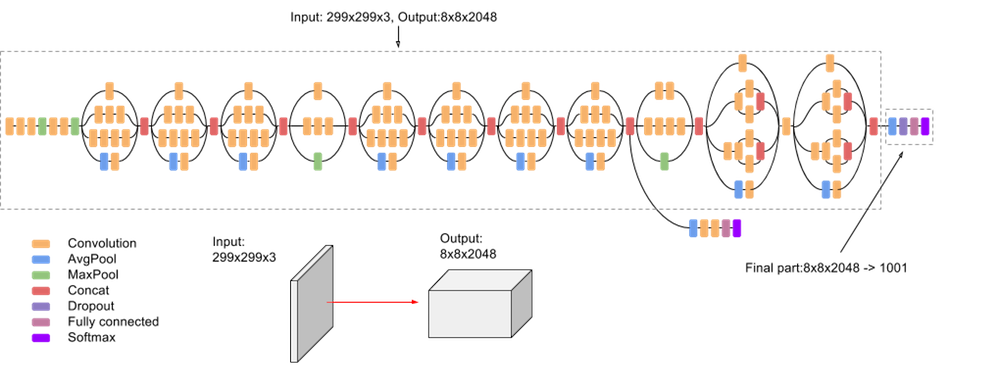

Vamos a cargar los pesos obtenidos de entrenar Inception en el dataset Imagenet, indicando además que no se carge la última sección de la red, que es específica para ese challenge. Luego vamos a especificar nuevas capas que se ajustan a la salida que necesitamos para CIFAR-10.

In [ ]:
from keras.applications.inception_v3 import InceptionV3

pretrained = InceptionV3(input_shape=(224, 224, 3),
                         weights='imagenet',
                         include_top=False)

El siguiente paso es "congelar" las capas de InceptionV3, de forma de no tener que entrenarlas. Veamos antes el resumen de la arquitectura de InceptionV3 (observar la cantidad de parámetros entrenables):

In [ ]:
pretrained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_102 (Conv2D)         (None, 111, 111, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_102[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalizati

### Ejercicio 9: "Congelando" capas

Ahora, si, congelemos las capas, y volvamos a revisar la cantidad de parámetros entrenables. Esto se logra simplemente iterando la lista de capas del modelo (atributo `layers`) y seteando el atributo `trainable` de cada una de ellas en `False`:

In [ ]:
for layer in pretrained.layers:
    layer.trainable = False

In [ ]:
pretrained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_102 (Conv2D)         (None, 111, 111, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_102[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalizati

### Construyendo un nuevo modelo a partir de InceptionV3

Un detalle a resolver es que InceptionV3 espera imágenes de (224, 224) en vez de (32,32). Por esta razón, al crear el modelo, enseguida de la capa de entrada que teníamos antes,  agregaremos una capa `Lambda`. Esta capa no tiene parámetros y se encargará de ajustar el tamaño de las imágenes.

In [ ]:
import tensorflow as tf
from keras.layers import Lambda

transfer_model = Sequential()
transfer_model.add(Input(shape=(32,32,3)))
transfer_model.add(Lambda(lambda x: tf.image.resize(x, (224, 224))))

Ahora podemos agregar todas las capas de InceptionV3 en un sólo paso, pasando como parámetro a `add`, el modelo pre-entrenado entero. Keras se encarga de resolver los detalles:

In [ ]:
transfer_model.add(pretrained)

### Ejercicio 10: Las capas finales

Finalmente, de forma similar a como vimos con la arquitectura anterior, necesitamos "aplastar" la salida de la última capa congelada de InceptionV3, y luego agregar nuestras propia capa de salida. Esta vez en vez de utilizar `Flatten`, utilizaremos la capa `GlobalAveragePooling2D`, para reducir la cantidad de parámetros y entrenar más rápido:

Agregar al modelo:
* una capa `GlobalAveragePooling2D`
* una capa `Dense` de salida con 10 neuronas y activación `softmax`

Para entender el funcionamiento de `GlobalAveragePooling2D` ver: https://keras.io/api/layers/pooling_layers/global_average_pooling2d/


In [ ]:
from keras.layers import GlobalAveragePooling2D

transfer_model.add(GlobalAveragePooling2D())
transfer_model.add(Dense(10, activation='softmax'))

### Preprocesar la entrada

Cada modelo puede aplicar diferentes métodos de preprocesamiento. Es importante que las imágenes siempre sean tratadas de igual forma, sino, es posible que los resultados no sean los esperados. Keras nos provee acceso a las funciones de preprocesamiento de InceptionV3 con el método `preprocess_input`. Debemos aplicar el preprocesamiento a ambas particiones (entrenamiento y evaluación) tal cual son provistas por `cifar10.load_data()`. Documentación: https://keras.io/api/applications/inceptionv3/

In [ ]:
from keras.applications.inception_v3 import preprocess_input

# volvemos a cargar los datos en su formato original
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# preprocesamos los conjuntos de entrenamiento y evaluación
x_train_pre = preprocess_input(x_train)
x_test_pre = preprocess_input(x_test)

### Entrenando la nueva red

Con la arquitectura completa, ya podemos compilar y entrenar el modelo. Esta vez, reducimos la cantidad de épocas, porque cada época demora más, debido a que la pasada hacia adelante es más costosa (hacia atrás tenemos unos "pocos" pesos para actualizar). De todas formas, los resultados con apenas tres épocas deberían ser bastante mejores que los obtenidos anteriormente.

In [ ]:
opt = Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

transfer_model.fit(x_train_pre, y_train, validation_split=0.1, epochs=3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/3
1407/1407 [==============================] - 110s 75ms/step - los

### Evaluación final

Para terminar, obtendremos la accuracy del nuevo modelo sobre el conjunto de evaluación, como hicimos antes:

In [ ]:
preds = transfer_model.predict(x_test_pre)
print (accuracy_score(y_test, preds.argmax(axis=1)))

# código adicional
print ('\n------------------------ CLASSIFICATION REPORT ------------------------')
print(classification_report(y_true = y_test, y_pred = preds.argmax(axis=1), digits = 3))

313/313 [==============================] - 22s 62ms/step
0.8516

------------------------ CLASSIFICATION REPORT ------------------------
              precision    recall  f1-score   support

           0      0.876     0.853     0.864      1000
           1      0.884     0.945     0.913      1000
           2      0.861     0.821     0.840      1000
           3      0.714     0.758     0.736      1000
           4      0.814     0.821     0.817      1000
           5      0.815     0.811     0.813      1000
           6      0.877     0.853     0.865      1000
           7      0.864     0.865     0.865      1000
           8      0.893     0.908     0.900      1000
           9      0.930     0.881     0.905      1000

    accuracy                          0.852     10000
   macro avg      0.853     0.852     0.852     10000
weighted avg      0.853     0.852     0.852     10000

